<a href="https://colab.research.google.com/github/korede97/Hamoye_ML_Externship/blob/main/006_Weekly_ML_CodeClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '15px' font color='navy'>The Complete Machine Learning Externship:</font> 

<font size = '6px' font color='red'>Weekly ML Code Club: 006</font> 

<font size  = 5 font color = 'blue'>Time Series Analysis<font/>



# Time Series

The data consists of stock data of AABA collected from january 2006 to december 2019. The data is
collected on a daily sampling rate. The stock market is open for five days in a week, so we have data
points for Monday to Friday, excluding Saturday and Sunday. The data comprise the following
features.
* **Open**: the market opening price for the day
* **Close**: the market closing price for the day
* **High**: the highest price point reached for the day
* **Low**: The lowest point the price dropped to for the day
* **Volume**: The volume of stocks traded for the day
* **Name**: The name of the company stock traded
* **Date**: the date/timestam of the data

Task: Build a multivariate LSTM time series model using the close, high, low, and Volume features
to predict the opening(open) price of the stock market. Your predictions should be on a
daily basis.

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in
the field of deep learning. LSTM are very good for training models that are very dependent on
sequences of the data. Time series data as we know are a sequence of data points collected in an
orderly manner, where each data point is directly related to the preceding data point. Also LSTM are
very robust to non stationary data unlike the traditional ARIMA, AR and MA models which must be
modeled on non stationary data that has been made stationary by log differencing.

# Load the Dataset

In [327]:
# Import all necessary libraries 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [328]:
df = pd.read_csv("AABA_2006-01-01_to_2018-01-01.csv")

In [329]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


1. Perform Basic EDA and do some visualization.

In [330]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object

In [331]:
df["Date"] = pd.to_datetime(df["Date"]) #convert column to datetime
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Name              object
dtype: object

Text(0, 0.5, 'Open')

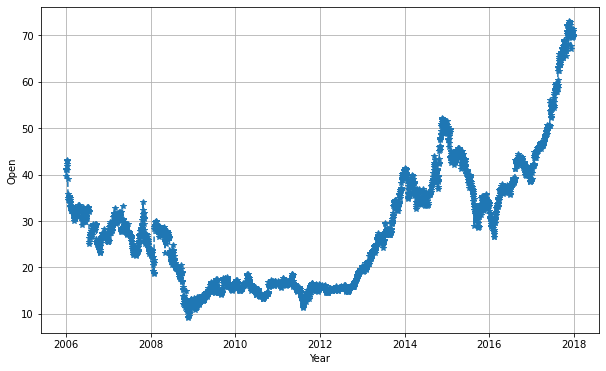

In [332]:
feature = "Open"
df.set_index("Date", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df[feature], '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel(feature)

Text(0, 0.5, 'High')

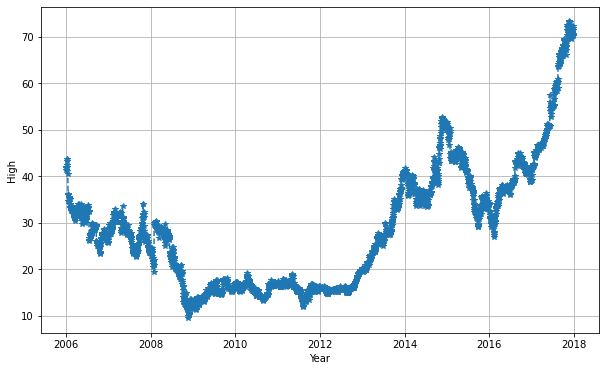

In [333]:
feature = "High"
# df.set_index("Date", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df[feature], '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel(feature)

Text(0, 0.5, 'Volume')

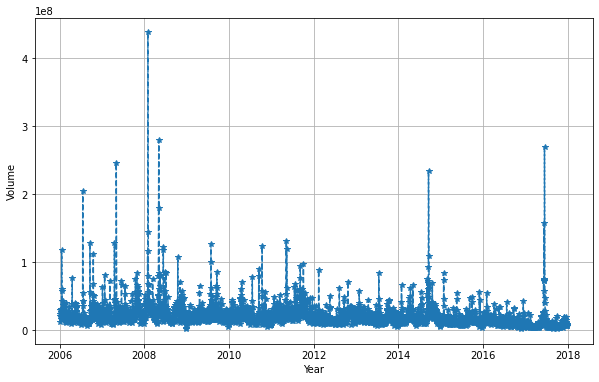

In [334]:
feature = "Volume"
# df.set_index("Date", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df[feature], '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel(feature)

2. Check for stationarity of the features
(not compulsory, because LSTM works well with both stationary and non stationary data)

In [335]:
#check for missing values
df.isnull().values.any()
#There are no missing values in our dataset however, in bid to explain how we handle 

False

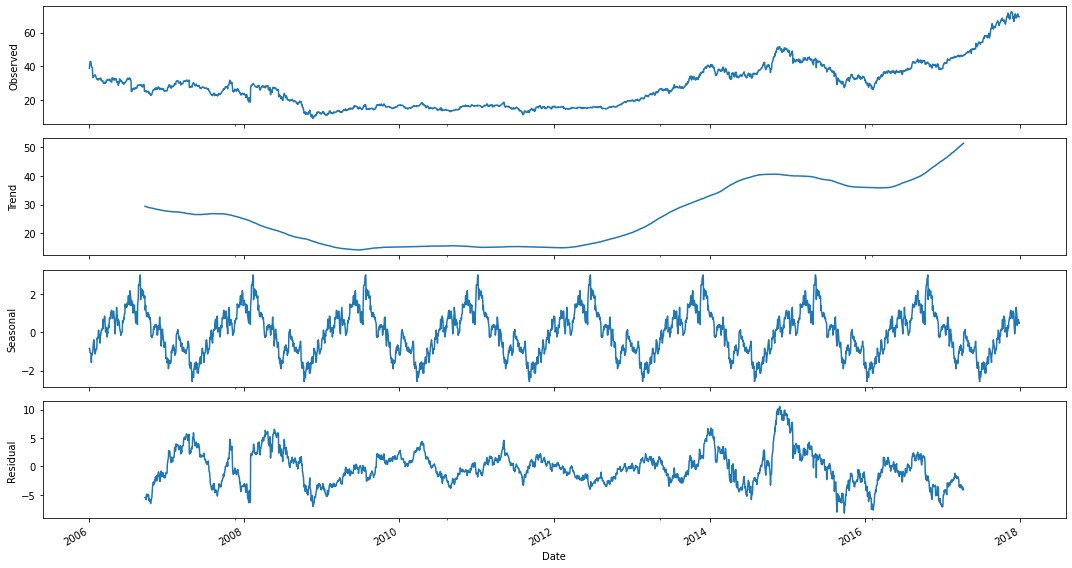

ADF Statistic: 0.6879736016669697
p-value: 0.9895947809462745
No. of lags used: 5
No. of observations used : 3013
Critical Values:
   1%: -3.432522213721007
   5%: -2.862499744326095
   10%: -2.567280896877994


In [336]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

feature = "Low"
decompose_series = sm.tsa.seasonal_decompose(df[feature], model='additive', freq = 365)
decompose_series.plot()
plt.show()

#The decomposed time series show an obvious increasing trend and seasonality variations. Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. This suggests that the data is not stationary. We will now perform an ADF test to confirm this speculation

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df[feature])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 


The p-value is greater than the critical value at a 5% significance level for Open, Close, High and low, BUT not Volume... (and, the ADF statistic is greater that any of the critical values obtain). Therefore, we fail to reject the null hypothesis

This suggests that the series is non-stationary (time-dependent)

There is evidence of stationarity for Volume


3. Convert all data points to floating point numbers

Note, according to the datatypes Volume was the only feature that needed to be converted. 

In [337]:
features = ['Open', 'Close', 'High', "Low", 'Volume']

df[features] = df[features].astype(float)
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729.0,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479.0,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610.0,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828.0,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338.0,AABA


5. Split the data into X and Y (X comprises of all the features and Y is the next data point in the open price after the selected
timestep you are training on)

5. Scale the dataset (recommended because of the optimizers in the network)

6. Preprocess the data to be in the right input shape (the input shape to the LSTM model should
be of the form (sample size, number of timesteps we are training on, number of features used
in training))

In [338]:
df.shape

(3019, 6)

In [339]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
print(train_size)
print(test_size)

2113
906


In [340]:
training_set = df.iloc[:train_size, 0:1].values
test_set = df.iloc[train_size:, 0:1].values

In [341]:
training_set

array([[39.69],
       [41.22],
       [40.93],
       ...,
       [34.85],
       [35.  ],
       [35.15]])

In [342]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

# df_ = df.drop(columns="Name")
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)
# test_set_scaled = scaler.fit_transform(test_set)
# y.reshape(-1,1)
# y_ = scaler.fit_transform(y)


In [343]:
# Creating a data structure with ?? time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 2113):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [344]:
X_train.shape

(2053, 60, 1)

### Training the model

In [347]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [348]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 20, batch_size = 32)


Epoch 1/20
65/65 [==============================] - 14s 106ms/step - loss: 0.0494
Epoch 2/20
65/65 [==============================] - 7s 112ms/step - loss: 0.0054
Epoch 3/20
65/65 [==============================] - 7s 111ms/step - loss: 0.0037
Epoch 4/20
65/65 [==============================] - 7s 110ms/step - loss: 0.0039
Epoch 5/20
65/65 [==============================] - 7s 110ms/step - loss: 0.0040
Epoch 6/20
65/65 [==============================] - 7s 113ms/step - loss: 0.0032
Epoch 7/20
65/65 [==============================] - 7s 111ms/step - loss: 0.0032
Epoch 8/20
65/65 [==============================] - 7s 113ms/step - loss: 0.0031
Epoch 9/20
65/65 [==============================] - 7s 111ms/step - loss: 0.0028
Epoch 10/20
65/65 [==============================] - 7s 112ms/step - loss: 0.0029
Epoch 11/20
65/65 [==============================] - 7s 111ms/step - loss: 0.0027
Epoch 12/20
65/65 [==============================] - 7s 112ms/step - loss: 0.0027
Epoch 13/20
65/65 [=====

In [349]:
training_set = df.iloc[:train_size, 0:1]
test_set = df.iloc[train_size:, 0:1]



In [350]:
dataset_total = pd.concat((training_set, test_set), axis = 0)
inputs = dataset_total[len(dataset_total) - len(training_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 966):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [351]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [352]:
X_test.shape

(906, 60, 1)

In [353]:
df.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=3019, freq=None)

In [354]:
df = pd.read_csv("AABA_2006-01-01_to_2018-01-01.csv")
df["Date"] = pd.to_datetime(df["Date"]) #convert column to datetime

In [355]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Name              object
dtype: object

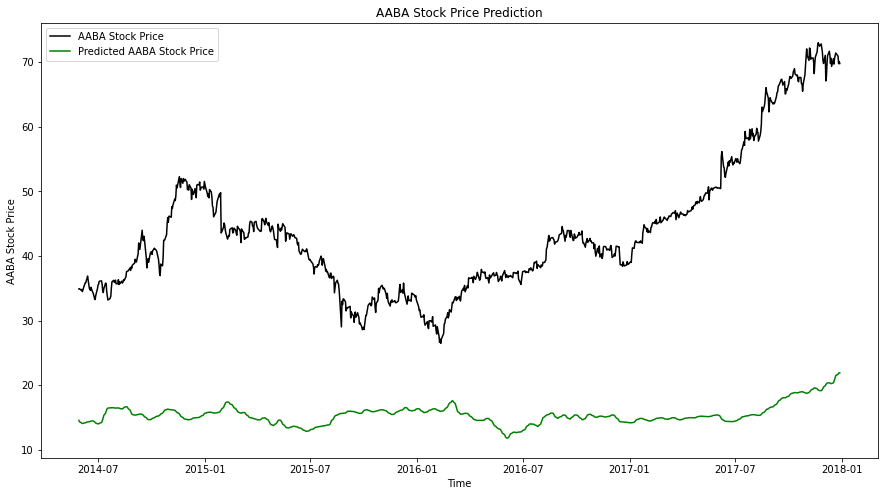

In [356]:
plt.plot(df.loc[2113:, "Date"], test_set , color = 'black', label = 'AABA Stock Price')
plt.plot(df.loc[2113:, "Date"], predicted_stock_price, color = 'green', label = 'Predicted AABA Stock Price')
plt.title('AABA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AABA Stock Price')
plt.legend()
plt.show()